# An illustration of the MARBLE method on the FitzHugh-Nagumo model

In [1]:
#!/usr/bin/env python3
# FHN_MARBLE_demo.py - Simplified FitzHugh-Nagumo model analyzed with MARBLE

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch

import MARBLE
from MARBLE import plotting, geometry
import MARBLE.preprocessing as mprep
import MARBLE.dynamics as dynamics

def get_pos_vel(n_trajectories,params, t, area, alpha=0.05):
    X0_range = dynamics.initial_conditions(n_trajectories, len(params), area)

    pos, vel = [], []
    for X0, m in zip(X0_range, params):
        p, v = dynamics.simulate_vanderpol(m, X0, t)
        pos.append(np.vstack(p))
        vel.append(np.vstack(v))

    pos, vel = dynamics.embed_parabola(pos, vel, alpha=alpha)
    return pos, vel

Simplified FitzHugh-Nagumo MARBLE Demo
Generating 100 trajectories...
Varying parameter: b in range [1.2, 1.3]


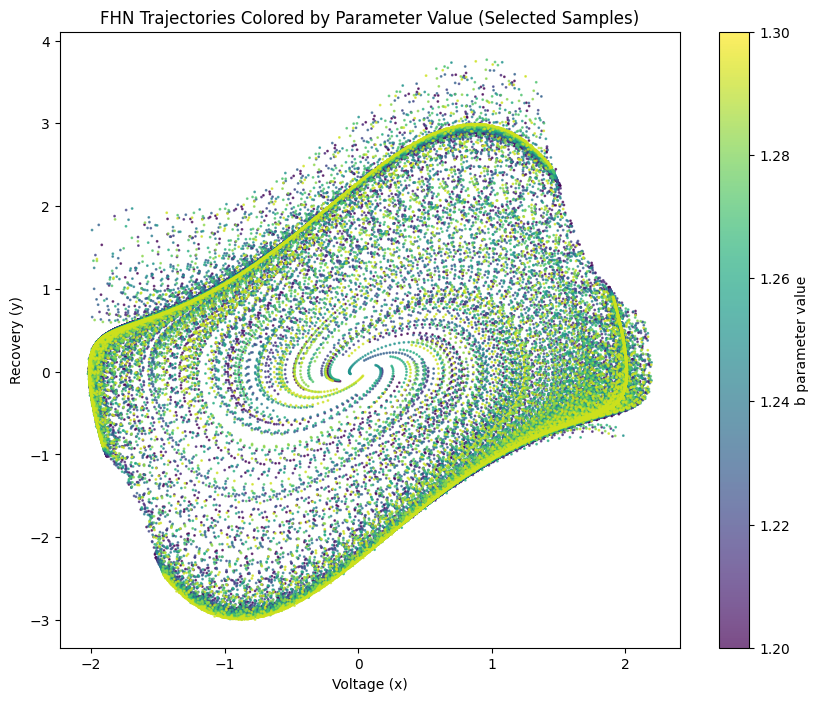

In [21]:
# Create directories for results
os.makedirs('temp_Figures', exist_ok=True)
os.makedirs('temp_Data', exist_ok=True)

# Set random seed for reproducibility
np.random.seed(42)

# Default FHN model parameters
FHN_PARAMS = {
    "a": 0.7,
    "b": 0.8,
    "tau": 12.5,
    "I_ext": 0.5
}

# MARBLE parameters
MARBLE_PARAMS = {
    'batch_size': 64,
    'epochs': 50,
    'lr': 0.01,
    'momentum': 0.9,
    'diffusion': True,
    'hidden_channels': [64, 32],
    'out_channels': 5,
    'batch_norm': True,
    'seed': 42
}

print("Simplified FitzHugh-Nagumo MARBLE Demo")
print("=" * 40)

# Setup
n_trajectories = 100  # Number of trajectories to simulate
t_span = np.linspace(0, 10, 100)  # Time points
area = [[-2.0, -0.8], [2.0, 2.0]]

# Parameter to vary (set to None for fixed parameters)
vary_param = 'b'
param_range = [0.5, 2.5]
n_params = 50
params = np.linspace(param_range[0], param_range[1], n_params)

print(f"Generating {n_trajectories} trajectories...")
if vary_param:
    print(f"Varying parameter: {vary_param} in range {param_range}")

pos_list,vel_list = get_pos_vel(n_trajectories,params, t_span, area,alpha=0.05)
# Visualize sample trajectories with colorbar showing parameter values
plt.figure(figsize=(10, 8))
scatter = None

# Plot every 4th trajectory to reduce clutter
plot_indices = range(0, n_params, 4)
for i in plot_indices:
    scatter = plt.scatter(pos_list[i][:, 0], pos_list[i][:, 1], 
                         c=np.ones(pos_list[i].shape[0]) * params[i],
                         cmap='viridis', alpha=0.7, s=1,
                         vmin=param_range[0], vmax=param_range[1])  # Set color range explicitly

plt.colorbar(scatter, label=f'{vary_param} parameter value')
plt.title('FHN Trajectories Colored by Parameter Value (Selected Samples)')
plt.xlabel('Voltage (x)')
plt.ylabel('Recovery (y)')
plt.savefig('temp_Figures/fhn_sample_trajectories.png', dpi=300, bbox_inches='tight')
plt.show()


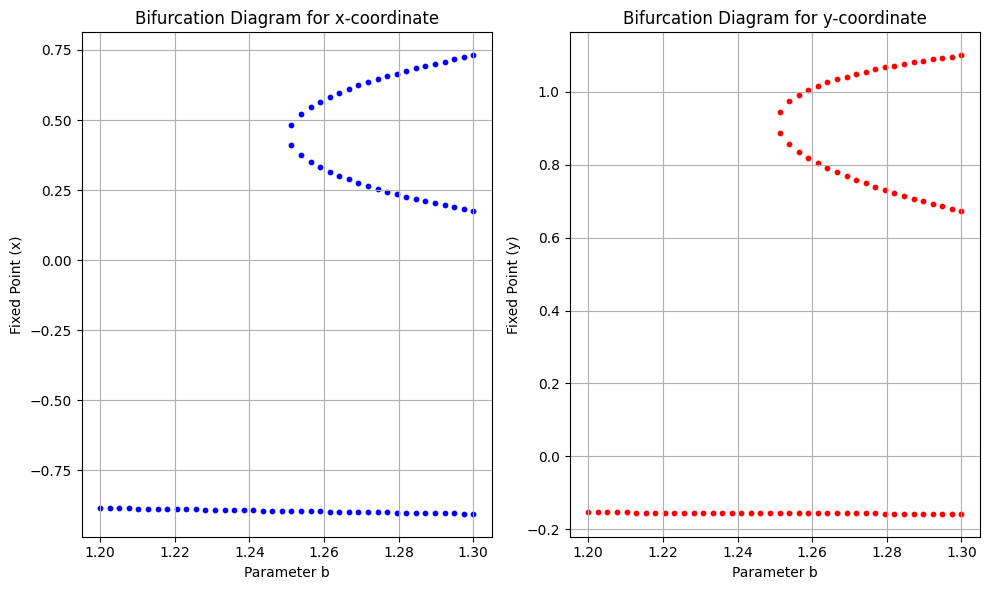

In [18]:
# Create bifurcation plot using the utility function
from fhn_phase_plane_utils import plot_bifurcation_diagram

# Setup other parameters (all parameters except the one we're varying)
other_params = FHN_PARAMS.copy()
del other_params[vary_param]  # Remove the parameter we're varying

# Call the bifurcation diagram function
fig, axes = plot_bifurcation_diagram(
    param_name=vary_param,
    param_range=param_range,
    other_params=other_params,
    num_points=n_params,
    figsize=(10, 6)
)

# Save the figure
plt.savefig('temp_Figures/bifurcation_diagram_a.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Prepare dataset and train model
data = MARBLE.construct_dataset(anchor=pos_list, vector=vel_list, spacing=0.03)

model = MARBLE.net(data, params=MARBLE_PARAMS)
model.fit(data, outdir='temp_Data')

# Transform data and calculate distances
data = model.transform(data)
data = MARBLE.distribution_distances(data)
data = MARBLE.embed_in_2D(data)


KeyboardInterrupt: 

<Figure size 400x400 with 0 Axes>

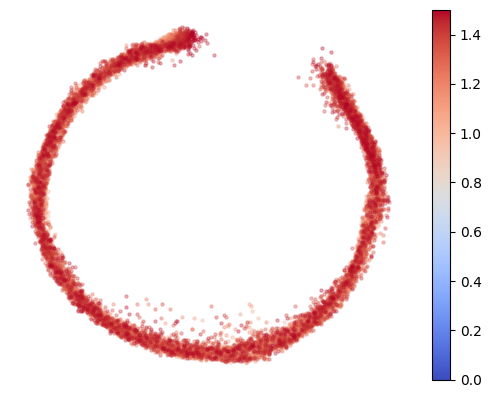

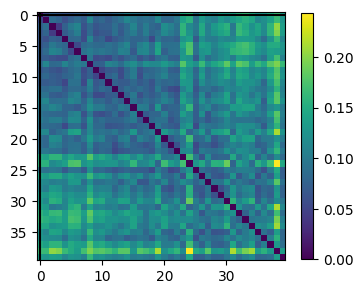

Performed MDS embedding on embedded results.
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
Y

<Figure size 400x400 with 0 Axes>

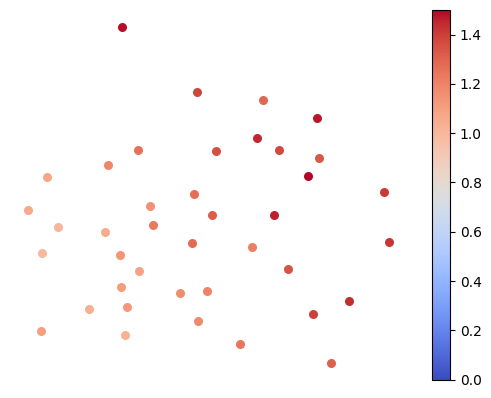

Demo completed. Results saved to temp_Figures/ directory.


In [33]:

# Visualize embeddings
plt.figure(figsize=(4, 4))
plotting.embedding(data, params[data.y.numpy().astype(int)])
plt.savefig('temp_Figures/fhn_embedding.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot distance matrix
plt.figure(figsize=(4, 4))
im = plt.imshow(data.dist, )
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.colorbar(im, shrink=0.8)
plt.savefig('temp_Figures/fhn_distances.png', dpi=300, bbox_inches='tight')
plt.show()

# MDS embedding
emb_MDS, _ = geometry.embed(data.dist, embed_typ='MDS')
plt.figure(figsize=(4, 4))
plotting.embedding(emb_MDS, params, s=30, alpha=1)
plt.savefig('temp_Figures/fhn_mds.png', dpi=300, bbox_inches='tight')
plt.show()

print("=" * 40)
print("Demo completed. Results saved to temp_Figures/ directory.")